-----------

# TRABAJO PRACTICO FINAL

### DIGITAL HOUSE: Data Science
### Junio 2022

<br>

## GRUPO 1
- Integrantes:
    - Gonzalo Barbot - PM: Project Manager
    - Agustin Stigliano - CDM: Code Development Manager
    - Fernando Dupont - PDM: Presentation Development Manager
    
<br>

## TEMA: Pronósticos sobre Series Temporales
<br>

-----

In [41]:
import numpy as np
from pprint import pprint
#from pandas import display
import pandas as pd
import matplotlib.pyplot as plt



import SmartSeries
SmartSeries.apply_dark_mode()

import datetime as dt
import locale, calendar
locale.setlocale(locale.LC_TIME, 'esp')

import warnings
warnings.filterwarnings('ignore')

In [42]:
data = pd.read_csv('customer_transaction_data.csv')
data = pd.merge(data, pd.read_csv('item_data.csv')[['category', 'item_id']], how='inner', on='item_id')
data['Ventas'] = data.quantity * (data.selling_price) + data.other_discount + data.coupon_discount

data.date = pd.to_datetime(data.date)
data.set_index('date', inplace=True)

data.head()

Visualizacion = False

# 1) EXPLORACION Y LIMPIEZA DEL DATASET

In [43]:
# Eliminación de los valores negativos en venta asumiendo que el descuento aplica hasta el total del valor del producto
data.loc[data.Ventas < 0, 'Ventas'] = 0

#### <u>ESTADISTICA DE CATEGORIAS SOBRE VENTAS</u>

In [44]:
block_1 = True
def x_1():
    global block_1
    try:
        if block_1: 1/0
        file = open('enumerate_1.log', 'r')
        i = file.read()
        file.close()
        i = int(i)
        i += 1
        i = str(i)
        file = open('enumerate_1.log', 'w')
        file.write(i)
        file.close()  
        return i
    
    except:
        file = open('enumerate_1.log', 'a')
        file.close()
        file = open('enumerate_1.log', 'w')
        file.write('1')
        file.close()
        block_1 = False
        return '1'

block_2 = True
def x_2():
    global block_2
    try:
        if block_2: 1/0
        file = open('enumerate_2.log', 'r')
        i = file.read()
        file.close()
        i = int(i)
        i += 1
        i = str(i)
        file = open('enumerate_2.log', 'w')
        file.write(i)
        file.close()  
        return i
    
    except:
        file = open('enumerate_2.log', 'a')
        file.close()
        file = open('enumerate_2.log', 'w')
        file.write('1')
        file.close()
        block_2 = False
        return '1'

In [45]:
def titulo(titulo):
    x = x_1()
    return ('='*80+'\n>> {}.\t'+titulo+ '\n'+'='*80).format(x)

def subtitulo(subtitulo):
    x = x_2()
    return ('>>>> {}) '+subtitulo+ '\n').format(x)

In [46]:
def statistic_tables_1(data):
# Categorias ordenadas de mayor a menor por desvio standard en sus ventas
    category_group = data.groupby('category')['Ventas'].describe()
    print (titulo('ANALISIS ESTADISTICO DE CATEGORIAS SOBRE VENTAS'))
    print (subtitulo('Categorias ordenadas de mayor a menor por desvio standard en sus ventas'))
    return category_group.sort_values(by='std', ascending=False)

In [47]:
def statistic_tables_2(data):
    print (titulo('"clients_demands_stats" & "clients_demands_cat" (+_norm) & "dummy_cat_time" (+_norm)'))
    # dummys de categoria
    demands_cat = pd.get_dummies(data['category'], drop_first=False)
    # Agregamos los dummies a la data
    data_extended_dummy = pd.concat([data, demands_cat], axis=1)
    print (subtitulo('Obtenemos valores estadisticos de las ventas realizadas por cliente'))
    clients_demands_stats = data_extended_dummy.groupby('customer_id')['Ventas'].describe()

    print (subtitulo('Obtenemos matriz dummy de las categorias que demandan por cliente'))
    mask = demands_cat.columns
    clients_demands_cat = data_extended_dummy.groupby('customer_id').sum()[mask]
    clients_demands_cat_norm = clients_demands_cat.astype('bool').astype('int')

    clients_demands_stats['Total_categorias'] = clients_demands_cat.astype(bool).sum(axis=1)

    print (subtitulo('Obtenemos matriz dummy de la frecuencia de ventas de las categorias '))
    dummy_cat_time = data_extended_dummy.groupby('date').sum()[mask]
    dummy_cat_time_norm = dummy_cat_time.astype('bool').astype('int')

    Dicto = {
        'clients_demands_stats': clients_demands_stats,
        'clients_demands_cat': clients_demands_cat,
        'clients_demands_cat_norm': clients_demands_cat_norm,
        'dummy_cat_time': dummy_cat_time,
        'dummy_cat_time_norm': dummy_cat_time_norm
    }

    return Dicto

In [48]:
category_group = statistic_tables_1(data)

print ('>> Podemos ver que solo 1 categoria tiene mayor valor de media que de desvío')
display (category_group.loc[category_group['mean']>= category_group['std']])

>> 1.	ANALISIS ESTADISTICO DE CATEGORIAS SOBRE VENTAS
>>>> 1) Categorias ordenadas de mayor a menor por desvio standard en sus ventas

>> Podemos ver que solo 1 categoria tiene mayor valor de media que de desvío


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Travel,247.0,105.341538,87.763536,0.0,53.43,89.05,120.575,587.73


#### <u>ESTADISTICA DE CLIENTES SOBRE VENTAS</u>

In [49]:
Dicto_1 = statistic_tables_2(data)

>> 2.	"clients_demands_stats" & "clients_demands_cat" (+_norm) & "dummy_cat_time" (+_norm)
>>>> 2) Obtenemos valores estadisticos de las ventas realizadas por cliente

>>>> 3) Obtenemos matriz dummy de las categorias que demandan por cliente

>>>> 4) Obtenemos matriz dummy de la frecuencia de ventas de las categorias 



In [50]:
print (titulo('BINARIZACION DE LOS CLIENTES POR CATEGORIA'))
clients_binarized_cat = Dicto_1['clients_demands_cat_norm'].T
display (clients_binarized_cat)

print (titulo('TOTAL DE CLIENTES POR CATEGORIA'))
display (clients_binarized_cat.sum(axis=1))

print (titulo('PORCENTAJES DE CLIENTES POR CATEGORIA'))
clients_cat_pct = (Dicto_1['clients_demands_cat_norm'].T.sum(axis=1) / len(data.customer_id.unique()) *100).sort_values(ascending=False)
display (clients_cat_pct)
if Visualizacion : clients_cat_pct.plot(kind='bar', figsize=(15,7)).set(title='GRAFICO DE BARRAS: PORCENTAJE DE CLIENTES POR CATEGORIA');


>> 3.	BINARIZACION DE LOS CLIENTES POR CATEGORIA


customer_id,1,2,3,4,5,6,7,8,9,10,...,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582
Alcohol,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,1,0,1,0,0
Bakery,1,1,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"Dairy, Juices & Snacks",1,1,0,1,1,0,1,1,0,1,...,1,1,0,0,1,1,0,1,1,1
Flowers & Plants,0,0,0,0,1,0,1,1,0,0,...,0,1,0,0,1,0,1,0,0,0
Fuel,0,0,1,0,1,0,1,1,1,1,...,1,1,1,1,1,1,0,0,1,1
Garden,0,0,0,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
Grocery,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Meat,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,0,1,1
Miscellaneous,0,0,0,0,1,1,0,1,1,0,...,0,1,0,1,0,0,0,1,1,0
Natural Products,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


>> 4.	TOTAL DE CLIENTES POR CATEGORIA


Alcohol                    384
Bakery                    1463
Dairy, Juices & Snacks    1165
Flowers & Plants           630
Fuel                       943
Garden                     199
Grocery                   1582
Meat                      1499
Miscellaneous              710
Natural Products          1564
Packaged Meat             1560
Pharmaceutical            1581
Prepared Food             1333
Restauarant                 68
Salads                     184
Seafood                   1150
Skin & Hair Care           924
Travel                     177
Vegetables (cut)            74
dtype: int64

>> 5.	PORCENTAJES DE CLIENTES POR CATEGORIA


Grocery                   100.000000
Pharmaceutical             99.936789
Natural Products           98.862200
Packaged Meat              98.609355
Meat                       94.753477
Bakery                     92.477876
Prepared Food              84.260430
Dairy, Juices & Snacks     73.640961
Seafood                    72.692794
Fuel                       59.608091
Skin & Hair Care           58.407080
Miscellaneous              44.879899
Flowers & Plants           39.823009
Alcohol                    24.273072
Garden                     12.579014
Salads                     11.630847
Travel                     11.188369
Vegetables (cut)            4.677623
Restauarant                 4.298357
dtype: float64

CONCLUSION: Hay 4 categorias que consumen casi todos de nuestros clientes (cercano a 100%), siguen 3 categorias superiores a 80%, siguen dos categorias que consumen el 60% de los clientes, y el resto por debajo de 40%

>> 6.	ANALISIS ESTADISTICO DE LOS CLIENTES SOBRE VENTAS


,count,mean,std,min,25%,50%,75%,max,Total_categorias,Alcohol,...,Natural Products,Packaged Meat,Pharmaceutical,Prepared Food,Restauarant,Salads,Seafood,Skin & Hair Care,Travel,Vegetables (cut)
customer_id,,,,,,,,,,,,,,,,,,,,,
1,1048.0,100.164246,1.221912e+02,0.00,46.6600,71.775,110.4250,1764.97,9,0,...,1,1,1,1,1,0,0,0,0,0
2,419.0,108.965632,1.540526e+02,0.00,46.6600,76.580,113.6300,2088.75,9,0,...,1,1,1,0,0,0,1,1,0,0
3,705.0,7219.773021,1.865318e+05,0.00,42.7400,81.570,206.2500,4952944.66,8,0,...,1,1,1,0,0,0,1,1,0,0
4,220.0,214.971682,3.795344e+02,7.48,63.7600,104.010,167.5950,2940.43,8,0,...,1,1,1,0,0,0,1,1,0,0
5,792.0,135553.058952,1.423555e+06,0.00,46.5725,94.035,170.8875,21742500.94,14,0,...,1,1,1,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,783.0,126685.069055,1.292698e+06,0.00,28.8500,65.540,113.6300,22719060.06,11,1,...,1,1,1,1,0,0,1,0,0,0
1579,1162.0,186.218795,2.811396e+02,0.00,53.1600,100.270,199.8200,3539.16,10,0,...,1,1,1,1,0,0,1,1,0,0
1580,529.0,32809.567713,6.065717e+05,0.00,49.5100,88.690,135.0000,13406896.06,9,1,...,1,1,1,1,0,0,0,0,0,0


>> 7.	GRAFICO DE BARRAS DE CANTIDAD DE CATEGORIAS TRANSACIONADAS POR CLIENTE


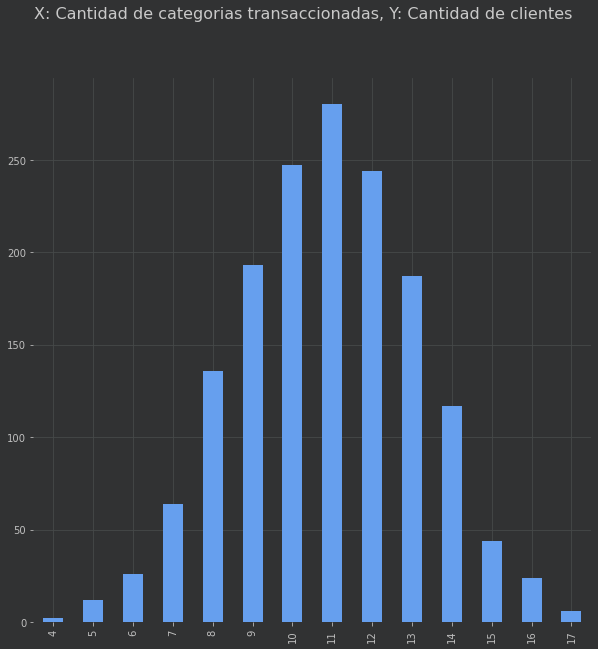

In [51]:
print (titulo('ANALISIS ESTADISTICO DE LOS CLIENTES SOBRE VENTAS'))
display (pd.concat([Dicto_1['clients_demands_stats'], clients_binarized_cat.T], axis=1))

plt.suptitle('X: Cantidad de categorias transaccionadas, Y: Cantidad de clientes', size=16)

Dicto_1['clients_demands_cat'].astype(bool).astype(int).sum(axis=1).value_counts(sort=False).sort_index().plot(kind='bar', figsize=(10,10));

print (titulo('GRAFICO DE BARRAS DE CANTIDAD DE CATEGORIAS TRANSACIONADAS POR CLIENTE'))

CONCLUSION: La mayoría de los clientes compra 11 categorias

# 2) Armado de la base de datos de entrenamiento

## Limpieza de outliers

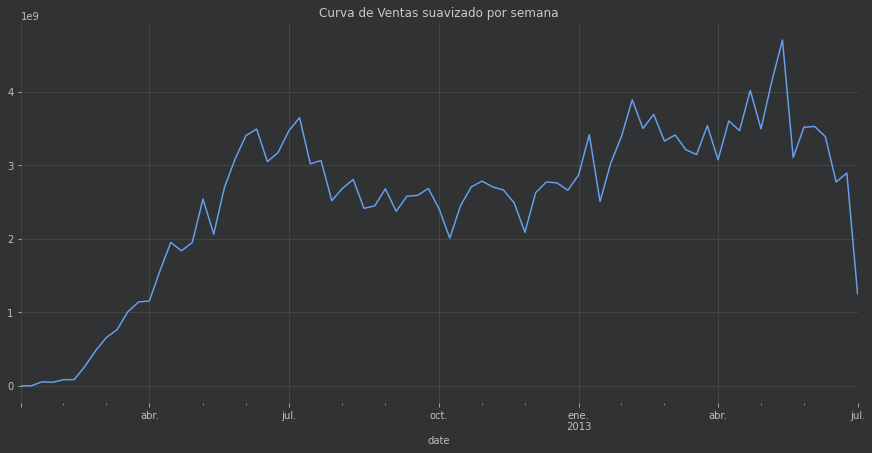

In [52]:
data.Ventas.resample('W').sum().plot(figsize=(15, 7))
plt.title('Curva de Ventas suavizado por semana');

Podemos notar que el punto de partida en la colecta de data no fue el mismo para todas las categorías, por lo que decidimos arrancar desde Abril 2012

También vemos que empieza a haber una caída pronunciada en las ventas, y asumimos que es debido a que se dejó de colectar data, por lo que decidimos terminar el período de entrenamiento a finales de Junio 2013

En conclusión, nuestro dataset va a ser durante el período de Abril 2012 - Junio 2013

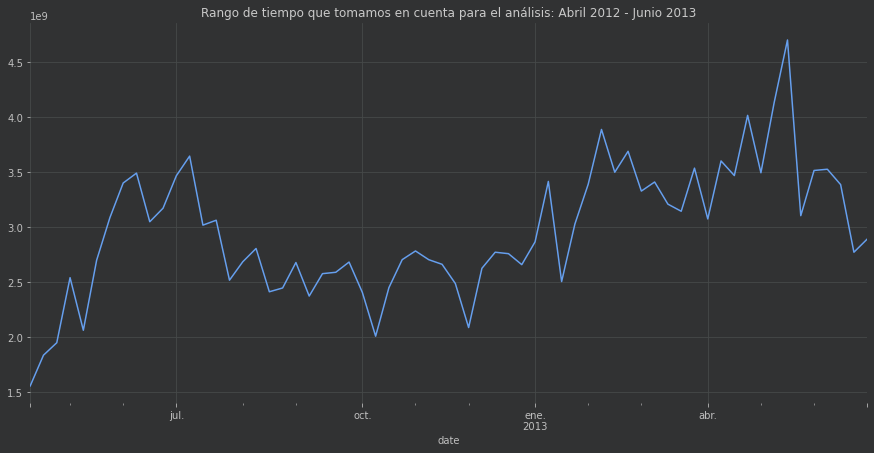

In [53]:
data = data.loc['2012-04-10':'2013-06-30']
data.Ventas.resample('W').sum().plot(figsize=(15,7))
plt.title('Rango de tiempo que tomamos en cuenta para el análisis: Abril 2012 - Junio 2013');

### Creacion de los targets que van a componer al modelo

In [54]:
df = pd.pivot_table(data, values='Ventas', index='date', columns='category')
# Hay una categoría con 1 día faltante, por lo que se debe eliminar
# Actualizamos el data original
data.drop(df[df.Miscellaneous.isna()].index, inplace=True)

In [55]:
# Actualización de las tablas estdísticas
category_group = statistic_tables_1(data)
Dicto_1 = statistic_tables_2(data)

# Actualizamos el dataset de targets
df = pd.pivot_table(data, values='Ventas', index='date', columns='category')

# Visualizamos el dataset de trabajo
print (titulo('CREACION DEL DATAFRAME DE EXTRACCION DE MUESTRAS'))
print (f'df.shape = {df.shape}')
df.head()

>> 8.	ANALISIS ESTADISTICO DE CATEGORIAS SOBRE VENTAS
>>>> 5) Categorias ordenadas de mayor a menor por desvio standard en sus ventas

>> 9.	"clients_demands_stats" & "clients_demands_cat" (+_norm) & "dummy_cat_time" (+_norm)
>>>> 6) Obtenemos valores estadisticos de las ventas realizadas por cliente

>>>> 7) Obtenemos matriz dummy de las categorias que demandan por cliente

>>>> 8) Obtenemos matriz dummy de la frecuencia de ventas de las categorias 

>> 10.	CREACION DEL DATAFRAME DE EXTRACCION DE MUESTRAS
df.shape = (446, 19)


category,Alcohol,Bakery,"Dairy, Juices & Snacks",Flowers & Plants,Fuel,Garden,Grocery,Meat,Miscellaneous,Natural Products,Packaged Meat,Pharmaceutical,Prepared Food,Restauarant,Salads,Seafood,Skin & Hair Care,Travel,Vegetables (cut)
date,,,,,,,,,,,,,,,,,,,
2012-04-10,303.92750,161.637857,196.454737,320.220000,9.632366e+06,142.12,125.835760,353.698462,8.408415e+06,101.781519,162.662000,349.128351,111.425882,NaN,NaN,400.082000,241.500000,NaN,NaN
2012-04-11,564.39500,123.934848,107.352059,498.263333,8.645962e+06,142.12,146.691058,222.319762,8.523802e+06,101.030875,134.233186,179.865346,120.607000,NaN,10.33,157.793333,146.041429,NaN,NaN
2012-04-12,778.18000,158.606944,116.793704,438.720000,8.897399e+06,213.36,164.758837,521.658136,6.558751e+06,114.137453,188.202250,195.612941,185.868837,NaN,41.32,169.131765,190.275455,32.77,NaN
2012-04-13,303.88125,182.599318,133.110698,124.310000,3.894734e+07,NaN,152.669070,521.257895,1.347417e+06,106.682081,158.045183,169.872827,210.620500,NaN,NaN,576.020000,162.681429,NaN,NaN
2012-04-14,213.36000,125.618571,206.520000,355.960000,9.133516e+06,NaN,126.721540,327.602143,1.096563e+07,126.068018,168.083239,198.341983,154.724138,NaN,92.97,181.875000,60.452857,NaN,NaN


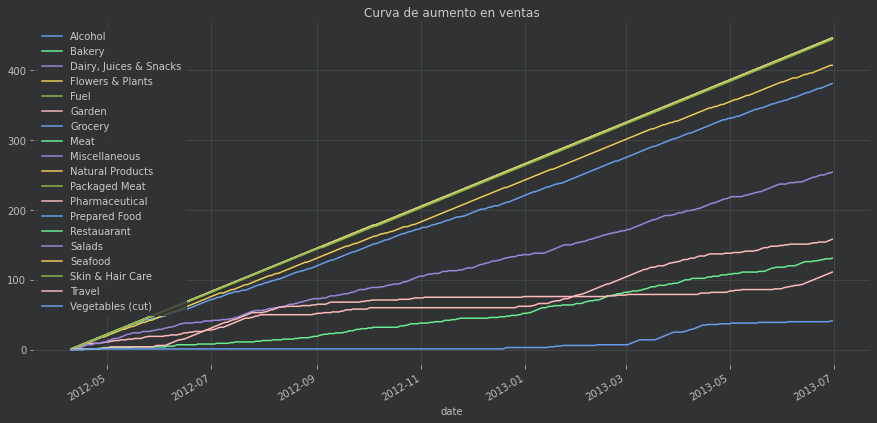

In [56]:
for cat in Dicto_1['dummy_cat_time_norm'].columns:
    Dicto_1['dummy_cat_time_norm'][cat].cumsum().plot(figsize=(15,7), label=cat).set(title='Curva de aumento en ventas');

plt.legend();

CONCLUSION: CUANDO LAS LINEAS SON HORIZONTAL ES PORQUE ESOS DIAS NO ESTUVO OCURRIENDO VENTAS

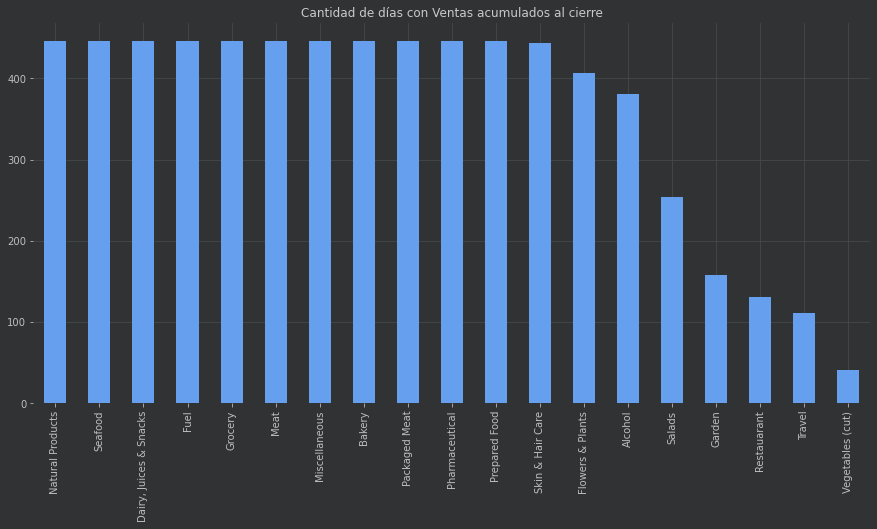

In [57]:
Dicto_1['dummy_cat_time_norm'].cumsum().iloc[-1,:].sort_values(ascending=False).plot(kind='bar', figsize=(15, 7)).set(title='Cantidad de días con Ventas acumulados al cierre');

**PARA DEFINIR LA PRIORIDAD SE DEBE CUMPLIR DOS REQUISITOS EN SIMULTANEO**

- QUE LA CATEGORIA TENGA ALTA FRECUENCIA
- QUE LA CATEGORIA TENGA ALTO PORCENTAJE DE CLIENTES

In [58]:
# requisito 1:
req_1_label = Dicto_1['dummy_cat_time_norm'].cumsum().iloc[-1,:].sort_values(ascending=False).loc[:'Prepared Food'].index

# requisito 2: 
req_2_label = clients_cat_pct.loc[:'Bakery'].index

# mixing up
high_priority_columns = req_1_label[req_1_label.isin(req_2_label)]


print (titulo('DEFINICION DE TARGETS DE ALTA PRIORIDAD'))
# dataset high priority
df_high_priority = df.loc[:, high_priority_columns]
print (subtitulo('Dataset: df_high_priority'))
display (df_high_priority)
print (subtitulo('Dataset: df_low_priority'))
df_low_priority = df.drop(columns=df_high_priority.columns)


>> 11.	DEFINICION DE TARGETS DE ALTA PRIORIDAD
>>>> 9) Dataset: df_high_priority



,Natural Products,Grocery,Meat,Bakery,Packaged Meat,Pharmaceutical
date,,,,,,
2012-04-10,101.781519,125.835760,353.698462,161.637857,162.662000,349.128351
2012-04-11,101.030875,146.691058,222.319762,123.934848,134.233186,179.865346
2012-04-12,114.137453,164.758837,521.658136,158.606944,188.202250,195.612941
2012-04-13,106.682081,152.669070,521.257895,182.599318,158.045183,169.872827
2012-04-14,126.068018,126.721540,327.602143,125.618571,168.083239,198.341983
...,...,...,...,...,...,...
2013-06-26,103.016559,112.263581,223.138889,149.655882,144.156222,292.195754
2013-06-27,100.582025,120.195221,392.826829,151.791714,162.264539,222.045030
2013-06-28,87.684000,130.841667,228.294590,116.581364,161.924259,189.297044


>>>> 10) Dataset: df_low_priority



# 3) VISUALIZACION



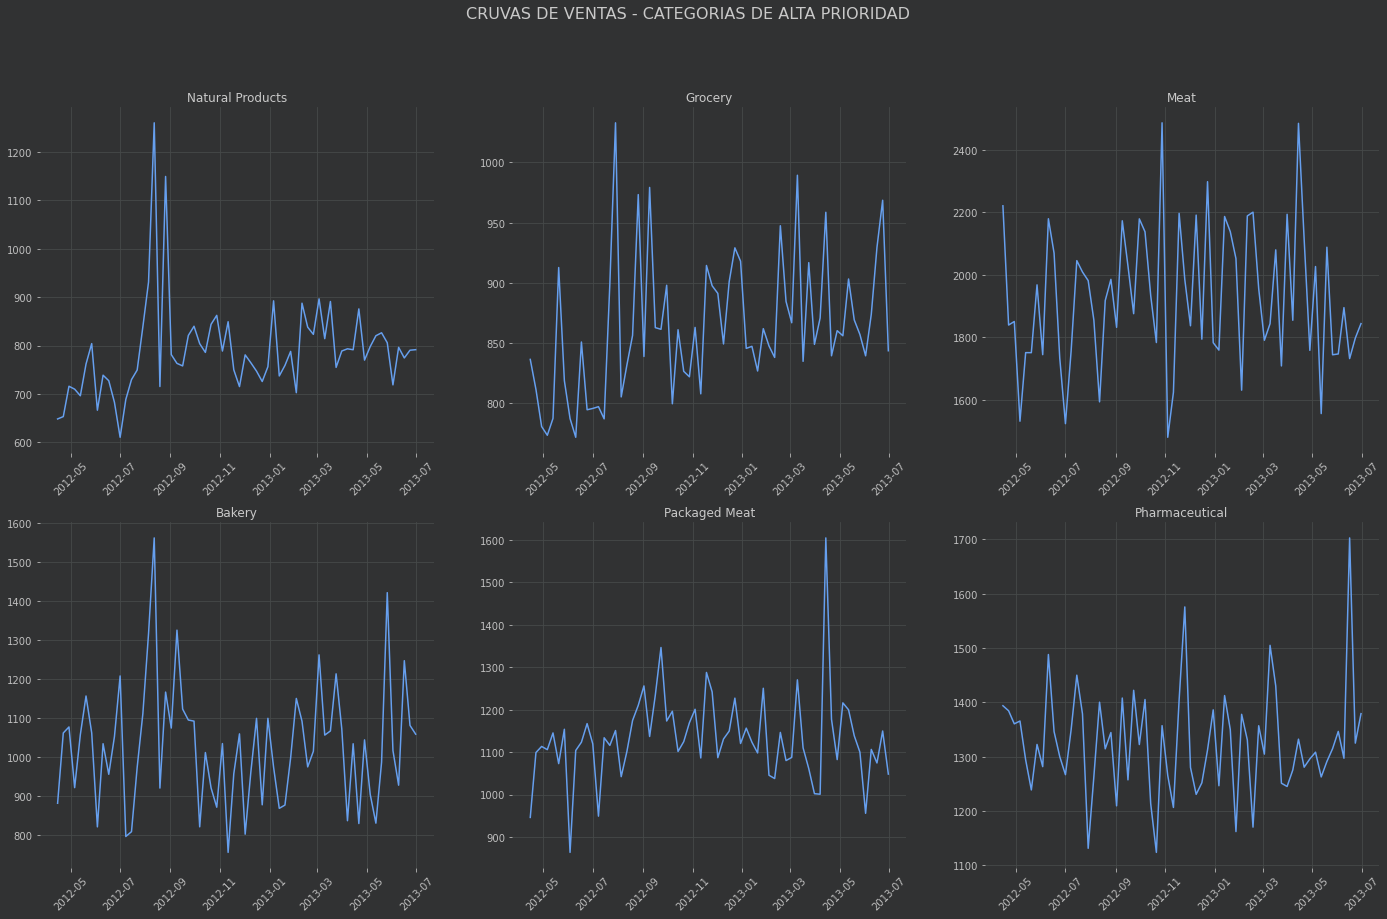

In [59]:
df_high_priority_W = df_high_priority.resample('W').sum()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24,14))

fig.suptitle('CRUVAS DE VENTAS - CATEGORIAS DE ALTA PRIORIDAD', size=16)

for j, elemento in enumerate(list(df_high_priority_W.columns)):
    
    if j < len(list(df_high_priority_W.columns)) /2:
        ax[0][j].tick_params('x', labelrotation=45)
        ax[0][j].set(title=elemento)
        ax[0][j].plot(df_high_priority_W[elemento])

    else:
        ax[1][j-3].tick_params('x', labelrotation=45)
        ax[1][j-3].set(title=elemento)
        ax[1][j-3].plot(df_high_priority_W[elemento])

Seleccionamos como primer target "Meat"

# 4) Seleccion y exportación de datos

In [60]:
df_high_priority.Meat.to_frame().to_csv('target_meat.csv')

In [61]:
df_high_priority.Meat

date
2012-04-10    353.698462
2012-04-11    222.319762
2012-04-12    521.658136
2012-04-13    521.257895
2012-04-14    327.602143
                 ...    
2013-06-26    223.138889
2013-06-27    392.826829
2013-06-28    228.294590
2013-06-29    225.785143
2013-06-30    279.030000
Name: Meat, Length: 446, dtype: float64